# Making some quick calculations to get $F_{ij}$ working for $C_l^{TT},C_l^{TE},C_l^{EE}$ observables

In [249]:
import crosspower as cp
#import FisherCl as fcl
#import FisherCl2 as fcl
#from numpy.linalg import eigh
import camb

# set plotting to be in the notebook instead of its own qt window
%matplotlib inline

In [254]:
# set cosmological parameters

cosParams = {
        'H0'    : None, #67.51, #setting H0=None allows cosmomc_theta to be used instead
        'cosmomc_theta'           : 1.04087e-2,
        'ombh2' : 0.02226,
        'omch2' : 0.1193,
        'omk'   : 0,
        'tau'   : 0.063,

        'As'    : 2.130e-9,
        'ns'    : 0.9653,
        'r'     : 0,
        'kPivot': 0.05,
    
        'w'     : -1,

        # if fiducial mnu is changed, need to adjust omch2 as well
        'mnu'   : 0.06, # (eV)
        #'mnu'   : 0.058, # Lloyd suggested this value for fiducial; adjust omch2 if I do use it
        'nnu'   : 3.046,
        'standard_neutrino_neff'  : 3.046,
        'num_massive_neutrinos'   : 1,
        'neutrino_hierarchy'      : 'normal'}


In [255]:
# set cosmological parameters
# step sizes from Kevin's SPT-3G forecasting notebook
"""params_base_theta={'H0':None,'cosmomc_theta':fish_param(1.04076967/100,0.000323773),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873,0.0115),
                           'ns':fish_param( 0.9681,0.0044),
                           'lmax':6000,'lens_potential_accuracy':5.0}"""
#                   ('lcdm_mnu',{'mnu':fish_param(.06,0.01)}),
"""
cosParams = {
        'H0'    : None, #67.51, #setting H0=None allows cosmomc_theta to be used instead
        'cosmomc_theta'           : 1.04076967e-2,
        'ombh2' : 0.02227,
        'omch2' : 0.1413-0.02227,
        'omk'   : 0,
        'tau'   : 0.067,

        'As'    : 1.873e-9,
        'ns'    : 0.9681,
        'r'     : 0,
        'kPivot': 0.05,

        # if fiducial mnu is changed, need to adjust omch2 as well
        'mnu'   : 0.06, # (eV)
        #'mnu'   : 0.058, # Lloyd suggested this value for fiducial; adjust omch2 if I do use it
        'nnu'   : 3.046,
        'standard_neutrino_neff'  : 3.046,
        'num_massive_neutrinos'   : 1,
        'neutrino_hierarchy'      : 'normal'}
"""

"\ncosParams = {\n        'H0'    : None, #67.51, #setting H0=None allows cosmomc_theta to be used instead\n        'cosmomc_theta'           : 1.04076967e-2,\n        'ombh2' : 0.02227,\n        'omch2' : 0.1413-0.02227,\n        'omk'   : 0,\n        'tau'   : 0.067,\n\n        'As'    : 1.873e-9,\n        'ns'    : 0.9681,\n        'r'     : 0,\n        'kPivot': 0.05,\n\n        # if fiducial mnu is changed, need to adjust omch2 as well\n        'mnu'   : 0.06, # (eV)\n        #'mnu'   : 0.058, # Lloyd suggested this value for fiducial; adjust omch2 if I do use it\n        'nnu'   : 3.046,\n        'standard_neutrino_neff'  : 3.046,\n        'num_massive_neutrinos'   : 1,\n        'neutrino_hierarchy'      : 'normal'}\n"

In [256]:
# get a matterPower object
reload(cp)
myPk = cp.matterPower(**cosParams)

zs.size:  998


In [278]:
# copy some setup from FisherCl2.py

#myParams = myPk.cosParams
myParams = cosParams
nz = 1000

# parameters list:
#nCosParams = 7 # 6 LCDM + Mnu
#paramList = ['ombh2','omch2','cosmomc_theta','As','ns','tau','mnu']
nCosParams = 8 # 6 LCDM + Mnu + w
paramList = ['ombh2','omch2','cosmomc_theta','As','ns','tau','mnu','w']
# step sizes for discrete derivatives: must correspond to paramList entries!
#   from Allison et. al. (2015) Table III.
#deltaP = [0.0008,0.0030,0.0050e-2,0.1e-9,0.010,0.020,0.020] #mnu one in eV
deltaP = [0.0008,0.0030,0.0050e-2,0.1e-9,0.010,0.020,0.020,0.3] #mnu one in eV

# step sizes from Kevin's SPT-3G forecasting notebook
"""params_base_theta={'H0':None,'cosmomc_theta':fish_param(1.04076967/100,0.000323773),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873,0.0115),
                           'ns':fish_param( 0.9681,0.0044),
                           'lmax':6000,'lens_potential_accuracy':5.0}"""
#                   ('lcdm_mnu',{'mnu':fish_param(.06,0.01)}),
#deltaP = [0.0002,0.0011,0.000323773,0.0115e-9,0.0044,0.013,0.01]

# cut deltaP in half to see effect
#deltaP = np.array(deltaP)/2.

# double deltaP to see effect
#deltaP = np.array(deltaP)*2.

# get more parameter sets for numeric differentiation
print 'creating parameter sets for making discrete derivatives...'
myParamsUpper = []
myParamsLower = []
myPksUpper = []
myPksLower = []
for cParamNum in range(nCosParams):
    #print 'creating matter power spectra for ',paramList[cParamNum],' derivative...'
    print 'creating parameter set for ',paramList[cParamNum],' derivative...'
    # add parameter dictionary to lists; HAVE TO BE COPIES!!!
    myParamsUpper.append(myParams.copy())
    myParamsLower.append(myParams.copy())
    # modify parameter number cParamNum in dictionaries
    myParamsUpper[cParamNum][paramList[cParamNum]] += deltaP[cParamNum]
    myParamsLower[cParamNum][paramList[cParamNum]] -= deltaP[cParamNum]

    
    # toggle this section off for comparison with Kevin's Fisher result:
    # actually, don't use it generally, since it's simpler without.
    # toggle this on to make comparisons with Byeonghee's result
    """
    # check for mnu modification and adjust omch2 if necessary
    if paramList[cParamNum] == 'mnu':
        omch2Index = np.where(np.array(paramList) == 'omch2')[0][0]
        deltaOmnh2 = deltaP[cParamNum]/94 #eq.n 12 from Wu et. al.
        #deltaOmnh2 = pars.omegan*(pars.H0/100)**2 # probably a better measure of omega_nu
        # note the -=,+= signs get reversed in next 2 lines compared to above
        myParamsUpper[cParamNum][paramList[omch2Index]] -= deltaOmnh2
        myParamsLower[cParamNum][paramList[omch2Index]] += deltaOmnh2
    """

    #print 'cPramNum: ',cParamNum,', param name: ',paramList[cParamNum]
    #print 'myParamsUpper[cParamNum][paramList[cParamNum]]: ',myParamsUpper[cParamNum][paramList[cParamNum]]
    #print 'myParamsLower[cParamNum][paramList[cParamNum]]: ',myParamsLower[cParamNum][paramList[cParamNum]]
    #print 'deltaP[cParamNum]: ',deltaP[cParamNum]

    # create matter power objects and add to lists
    # really I just need matterPower.pars, but this is a fast way to code it
    #myPksUpper.append(cp.matterPower(nz=nz,**myParamsUpper[cParamNum]))
    #myPksLower.append(cp.matterPower(nz=nz,**myParamsLower[cParamNum]))
    
    # switch to using just pars objects.  No longer "myPks", should be renamed
    myPksUpper.append(cp.matterPower.getPars(myPk,**myParamsUpper[cParamNum]))
    myPksLower.append(cp.matterPower.getPars(myPk,**myParamsLower[cParamNum]))



creating more matter power objects...
creating parameter set for  ombh2  derivative...
creating parameter set for  omch2  derivative...
creating parameter set for  cosmomc_theta  derivative...
creating parameter set for  As  derivative...
creating parameter set for  ns  derivative...
creating parameter set for  tau  derivative...
creating parameter set for  mnu  derivative...
creating parameter set for  w  derivative...


In [279]:
def checkPars(pars):
    H0 = pars.H0
    print 'ombh2: ',pars.omegab*(H0/100)**2
    print 'omch2: ',pars.omegac*(H0/100)**2
    print 'H_0: ',H0, '(proxy for theta?)'
    #print 'initial condition vector: ',pars.InitialConditionVector
    print 'As: ',pars.InitPower.ScalarPowerAmp[0]
    print 'ns: ',pars.InitPower.an[0]
    print 'tau: ',pars.Reion.optical_depth
    #print 'omega_n: ',pars.omegan
    print 'omega_n*94*h**2: ',pars.omegan*94*(H0/100)**2
    
    #print '\n'
    #print pars
    
#checkPars(parsTest)
if False:
    for cParamNum in range(nCosParams):
        print '\nContents of pars objects for parameter set ',cParamNum+1,' for parameter ',paramList[cParamNum], \
              ' with delta ',deltaP[cParamNum]
        checkPars(myPksUpper[cParamNum])
        checkPars(myPksLower[cParamNum])

In [300]:
# get all cross power spectra
lmax = 2000 # may want to match lmax in other Fisher calculation
pars = myPk.pars
#pars.set_for_lmax(lmax, lens_potential_accuracy=0)
# try kicking it up for comaprison against Kevin's result
lensLmax = lmax #3*lmax
lpa = 5.0 # set_for_lmax also sets lensing to be non-linear if lens_potential_accuracy>0
#aBoost = 1
#aBoost = 2
aBoost = 3
#aBoost = 4
#aBoost = 5
pars.set_for_lmax(lensLmax, lens_potential_accuracy=lpa)
pars.set_accuracy(AccuracyBoost=aBoost)

#calculate results for these parameters
print 'getting Cl power spectrum'
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars)
#for name in powers: print name

#get the total lensed CMB power spectra versus unlensed
#myClName = 'total'
myClName = 'unlensed_scalar'
myCl = powers[myClName]

#totCl=powers['total']
#unlensedCl=powers['unlensed_scalar']
print myCl.shape
#Python Cl arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).

# re-arrange the data structure to be consistent with code in FisherMatrix
nMaps = 2 # T,E
crossCls      = np.zeros((nMaps,nMaps,           lmax))
crossClsPlus  = np.zeros((nMaps,nMaps,nCosParams,lmax))
crossClsMinus = np.zeros((nMaps,nMaps,nCosParams,lmax))

crossCls[0,0] = myCl[:lmax,0] # TT
crossCls[0,1] = myCl[:lmax,3] # TE
crossCls[1,0] = myCl[:lmax,3] # ET
crossCls[1,1] = myCl[:lmax,1] # EE

# get the perturbed versions
for paramNum in range(nCosParams):
    print 'getting Cl power spectra for parameter ',paramList[paramNum]
    parsUpper = myPksUpper[paramNum] #.pars
    parsLower = myPksLower[paramNum] #.pars
    parsUpper.set_for_lmax(lensLmax, lens_potential_accuracy=lpa)
    parsLower.set_for_lmax(lensLmax, lens_potential_accuracy=lpa)
    parsUpper.set_accuracy(AccuracyBoost=aBoost)
    parsLower.set_accuracy(AccuracyBoost=aBoost)


    #calculate results for these parameters
    resultsUpper = camb.get_results(parsUpper)
    resultsLower = camb.get_results(parsLower)

    #get dictionary of CAMB power spectra
    powersUpper =resultsUpper.get_cmb_power_spectra(parsUpper)
    powersLower =resultsLower.get_cmb_power_spectra(parsLower)
    
    #get the selected power spectra
    myClUpper=powersUpper[myClName]
    myClLower=powersLower[myClName]
    
    #store them
    crossClsPlus[0,0,paramNum]  = myClUpper[:lmax,0] # TT
    crossClsPlus[0,1,paramNum]  = myClUpper[:lmax,3] # TE
    crossClsPlus[1,0,paramNum]  = myClUpper[:lmax,3] # ET
    crossClsPlus[1,1,paramNum]  = myClUpper[:lmax,1] # EE

    crossClsMinus[0,0,paramNum] = myClLower[:lmax,0] # TT
    crossClsMinus[0,1,paramNum] = myClLower[:lmax,3] # TE
    crossClsMinus[1,0,paramNum] = myClLower[:lmax,3] # ET
    crossClsMinus[1,1,paramNum] = myClLower[:lmax,1] # EE

print 'done'


getting Cl power spectrum
(2051, 4)
getting Cl power spectra for parameter  ombh2
getting Cl power spectra for parameter  omch2
getting Cl power spectra for parameter  cosmomc_theta
getting Cl power spectra for parameter  As
getting Cl power spectra for parameter  ns
getting Cl power spectra for parameter  tau
getting Cl power spectra for parameter  mnu
getting Cl power spectra for parameter  w
done


In [301]:
# more code from FisherMatrix.__init__
# create covariance matrix
print 'building covariance matrix... '

nCls = nMaps*(nMaps+1)/2 # This way removes redundancies, eg C_l^kg = C_l^gk
#covar = np.zeros((nCls,nCls,lmax+51))
#ells = np.arange(lmax+51)
covar = np.zeros((nCls,nCls,lmax))
ells = np.arange(lmax)

# create obsList to contain base nMaps representation of data label
obsList = np.zeros(nCls)

for map1 in range(nMaps):
    print 'starting covariance set ',map1+1,' of ',nMaps,'... '
    for map2 in range(map1, nMaps):
        covIndex1 = map1*nMaps+map2-map1*(map1+1)/2     # shortens the array
        obsList[covIndex1] = map1*nMaps+map2       # base nMaps representation
        for map3 in range(nMaps):
          for map4 in range(map3, nMaps):
            covIndex2 = map3*nMaps+map4-map3*(map3+1)/2 # shortens the array
            if covIndex1 <= covIndex2:
              covar[covIndex1,covIndex2] = (crossCls[map1,map3]*crossCls[map2,map4] + \
                                            crossCls[map1,map4]*crossCls[map2,map3] )/(2.*ells+1)
            else:                                       # avoid double calculation
              covar[covIndex1,covIndex2] = covar[covIndex2,covIndex1]

# invert covariance matrix
print 'inverting covariance matrix... '
# transpose of inverse of transpose is inverse of original
# need to do this to get indices in order that linalg.inv wants them
invCov = np.transpose(np.linalg.inv(np.transpose(covar[:,:,2:])))
ells = ells[2:]
print 'lmin = ',ells[0]
print 'obsList: ',obsList

building covariance matrix... 
starting covariance set  1  of  2 ... 
starting covariance set  2  of  2 ... 
inverting covariance matrix... 
lmin =  2
obsList:  [ 0.  1.  3.]


In [302]:
# save covar
# ell values go from 0 to lmax-1
#import pickle 
#pickle.dump(covar,open('covar.pkl','w'))

In [303]:
# get derivatives wrt parameters
print 'starting creation of C_l derivatives... '
#dClVecs = np.empty((nCls, nCosParams, lmax+51))
#Clzeros = np.zeros(lmax+51) # for putting into dClVecs when needed
dClVecs = np.empty((nCls, nCosParams, lmax))

for map1 in range(nMaps):
    print 'starting derivative set ',map1+1,' of ',nMaps,'... '
    for map2 in range(map1,nMaps):
        mapIdx  = map1*nMaps+map2 -map1*(map1+1)/2  
                                   # mapIdx = map index
        for pIdx in range(nCosParams):
            dClPlus  = crossClsPlus[map1,map2,pIdx]
            dClMinus = crossClsMinus[map1,map2,pIdx]
            dClVecs[mapIdx, pIdx] = (dClPlus-dClMinus)/(2*deltaP[pIdx])


starting creation of C_l derivatives... 
starting derivative set  1  of  2 ... 
starting derivative set  2  of  2 ... 


In [304]:
#Build Fisher matrix
lmin = 50 #to match Allison et. al. and justify no ISW effect
#multply vectorT,invcov,vector and add up
print 'building Fisher matrix from components...'
print 'invCov.shape: ',invCov.shape,', dClVecs.shape: ',dClVecs.shape
Fij = np.zeros((nCosParams,nCosParams)) # indices match those in paramList
for i in range(nCosParams):
    print 'starting bin set ',i+1,' of ',nCosParams
    dClVec_i = dClVecs[:,i,:] # shape (nCls,nElls)
    for j in range(nCosParams):
        dClVec_j = dClVecs[:,j,:] # shape (nCls,nElls)
        # ugh.  don't like nested loops in Python... but easier to program...
        #for ell in range(lmin-2,lmax+51-2):
        for ell in range(lmin-2,lmax-2):
          myCov = invCov[:,:,ell]  #note invCov has no ell=0,1 but dClVecs do
          fij = np.dot(dClVec_i[:,ell+2],np.dot(myCov,dClVec_j[:,ell+2]))
          Fij[i,j] += fij
    
print 'creation of Fisher Matrix complete!\n'

# Have a look at it
print 'Fij:'
print Fij
# check eigenvalues
w,v = np.linalg.eigh(np.linalg.inv(Fij))
print 'eigenvalues of F_ij^-1:'
print w

building Fisher matrix from components...
invCov.shape:  (3, 3, 1998) , dClVecs.shape:  (3, 8, 2000)
starting bin set  1  of  8
starting bin set  2  of  8
starting bin set  3  of  8
starting bin set  4  of  8
starting bin set  5  of  8
starting bin set  6  of  8
starting bin set  7  of  8
starting bin set  8  of  8
creation of Fisher Matrix complete!

Fij:
[[  6.49374984e+10   2.06096301e+09   3.74664924e+11  -1.20127345e+16
   -1.60514561e+07   5.11882487e+07   3.26853039e+07   1.44589930e+08]
 [  2.06096301e+09   9.12818447e+07   1.37395435e+10  -3.78798948e+15
   -4.15729218e+06   1.61305633e+07   1.18762897e+06   6.23788369e+06]
 [  3.74664924e+11   1.37395435e+10   2.49009795e+12  -2.29997367e+17
   -4.55623907e+08   9.79822277e+08   2.17001679e+08   1.10559279e+09]
 [ -1.20127345e+16  -3.78798948e+15  -2.29997367e+17   8.81510961e+23
    1.25210693e+15  -3.75439989e+15  -1.71987369e+13  -1.67803653e+14]
 [ -1.60514561e+07  -4.15729218e+06  -4.55623907e+08   1.25210693e+15
    2.5

In [305]:
# add prior on Tau for comparison with Kevin's result
tauNum = 5
tauPrior = 1/0.02**2
print Fij[tauNum,tauNum]
Fij[tauNum,tauNum] = Fij[tauNum,tauNum] + tauPrior 
print Fij[tauNum,tauNum]

15990308.5226
15992808.5226


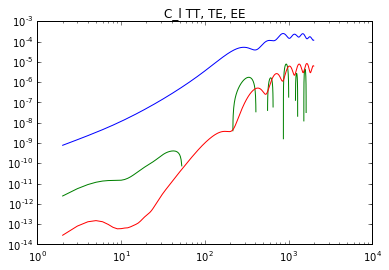

In [306]:
# just take a look at TT, TE, EE
plt.loglog(ells,crossCls[0,0,2:]*ells*(ells+1))
#plt.loglog(ells,crossCls[0,1,2:]*ells*(ells+1))
plt.loglog(ells,crossCls[1,0,2:]*ells*(ells+1))
plt.loglog(ells,crossCls[1,1,2:]*ells*(ells+1))
plt.title('C_l TT, TE, EE');

# Check out these uncertainties!

In [307]:
sigmas = np.sqrt(np.diag(np.linalg.inv(Fij)))
for i,p in enumerate(paramList):
    print p, sigmas[i]

ombh2 3.80885387057e-05
omch2 0.00057607315743
cosmomc_theta 1.98391611956e-05
As 8.32379912479e-11
ns 0.00174635031405
tau 0.0195795620757
mnu 0.188897719118
w 0.0139532209965


In [308]:
# get lensing and galaxy Fisher matrix to add
import FisherCl2 as fcl
import pickle
filehandler2 = open('Fisher_4_4e.obj', 'r') # this one also has dark energy w; no omega_m fix
#filehandler2 = open('Fisher_4_4d.obj', 'r') 
#filehandler2 = open('Fisher_4_4c.obj', 'r') 
#filehandler2 = open('Fisher_4_4b.obj', 'r') 
Fobj = pickle.load(filehandler2) 

print Fobj.obsList
print Fobj.paramList

[  0.   1.   2.   3.   4.   6.   7.   8.   9.  12.  13.  14.  18.  19.  24.]
['ombh2', 'omch2', 'cosmomc_theta', 'As', 'ns', 'tau', 'mnu', 'w', 'bin1', 'bin2', 'bin3', 'bin4']


In [309]:
# remake the kappa-g Fij with lmin=50 to match the other Fij
# make comparison against version with higher lmin
# copy some code from FisherMatrix.__init__

def makeFisher(Fobj,lmin):
    """ code copied from FisherMatrix.__init__
        Inputs:
            Fobj:
            lmin: minimum ell to make Fij
    """
    #Build Fisher matrix
    #multply vectorT,invcov,vector and add up
    print 'building Fisher matrix from components...'
    print 'invCov.shape: ',Fobj.invCov.shape,', dClVecs.shape: ',Fobj.dClVecs.shape
    nParams = Fobj.nParams
    lmax = 2000 #Fobj.lmax
    Fij = np.zeros((nParams,nParams)) # indices match those in paramList
    for i in range(nParams):
      print 'starting bin set ',i+1,' of ',nParams
      dClVec_i = Fobj.dClVecs[:,i,:] # shape (nCls,nElls)
      for j in range(nParams):
        dClVec_j = Fobj.dClVecs[:,j,:] # shape (nCls,nElls)
        # ugh.  don't like nested loops in Python... but easier to program...
        for ell in range(lmin-2,lmax-1): #-2 to match the indices
          myCov = Fobj.invCov[:,:,ell]
          fij = np.dot(dClVec_i[:,ell],np.dot(myCov,dClVec_j[:,ell]))
          
          Fij[i,j] += fij
    
    print 'creation of Fisher Matrix complete!\n'
    return Fij

In [310]:
lmin = 50
Fij2 = makeFisher(Fobj,lmin)
#Fij2 = makeFisher(Fobj,50)
sigmas2 = np.sqrt(np.diag(np.linalg.inv(Fij2)))

building Fisher matrix from components...
invCov.shape:  (15, 15, 1999) , dClVecs.shape:  (15, 12, 1999)
starting bin set  1  of  12
starting bin set  2  of  12
starting bin set  3  of  12
starting bin set  4  of  12
starting bin set  5  of  12
starting bin set  6  of  12
starting bin set  7  of  12
starting bin set  8  of  12
starting bin set  9  of  12
starting bin set  10  of  12
starting bin set  11  of  12
starting bin set  12  of  12
creation of Fisher Matrix complete!



In [311]:
print 'comparison of T,E sigmas with kappa,g sigmas:'
#sigmas2 = Fobj.getSigmas()
for i,p in enumerate(paramList):
    print p, sigmas[i],sigmas2[i]

comparison of T,E sigmas with kappa,g sigmas:
ombh2 3.80885387057e-05 0.000554303334438
omch2 0.00057607315743 0.00120972570401
cosmomc_theta 1.98391611956e-05 3.17596278766e-05
As 8.32379912479e-11 3.12909652595e-11
ns 0.00174635031405 0.00352117084085
tau 0.0195795620757 2.92905561958
mnu 0.188897719118 0.0184590840337
w 0.0139532209965 0.02090654782


# Combine the Fisher matrices and see smaller sigmas

In [312]:
print 'comparison of sigma(T,E), sigma(kappa,g), and sigma(T,E,kappa,g):\n'
#FijSum = Fij+Fobj.Fij[:nCosParams,:nCosParams]  #oops, that was the lmin=2 version
FijSum = Fij+Fij2[:nCosParams,:nCosParams]   # this one has lmin=50
#print FijSum
#print FijSum-Fij
#print FijSum-Fij2[:nCosParams,:nCosParams]
sigmas3 = np.sqrt(np.diag(np.linalg.inv(FijSum)))
#for i,p in enumerate(paramList):
#    print p, sigmas[i],sigmas2[i],sigmas3[i]
    
from prettytable import PrettyTable
t = PrettyTable(['Parameter', 'sigma(T,E)','sigma(k,g)','sigma(T,E,k,g)'])
for i,p in enumerate(paramList):
    t.add_row([p,"%5.3g" % sigmas[i],"%5.3g" % sigmas2[i],"%5.3g" % sigmas3[i]])
print t

comparison of sigma(T,E), sigma(kappa,g), and sigma(T,E,kappa,g):

+---------------+------------+------------+----------------+
|   Parameter   | sigma(T,E) | sigma(k,g) | sigma(T,E,k,g) |
+---------------+------------+------------+----------------+
|     ombh2     |  3.81e-05  |  0.000554  |    1.43e-05    |
|     omch2     |  0.000576  |  0.00121   |    0.000104    |
| cosmomc_theta |  1.98e-05  |  3.18e-05  |    3.32e-06    |
|       As      |  8.32e-11  |  3.13e-11  |    1.17e-11    |
|       ns      |  0.00175   |  0.00352   |    0.000769    |
|      tau      |   0.0196   |    2.93    |    0.00289     |
|      mnu      |   0.189    |   0.0185   |     0.0125     |
|       w       |   0.014    |   0.0209   |    0.00258     |
+---------------+------------+------------+----------------+


In [313]:
# the previous result fixed the biases for the combined sigmas.
# do a different version without fixing them
print 'comparison of sigma(T,E), sigma(kappa,g), and sigma(T,E,kappa,g):\n'
FijSum2 = Fij2.copy()
#print FijSum2
FijSum2[:nCosParams,:nCosParams] = FijSum2[:nCosParams,:nCosParams] + Fij
#print Fij2
#print FijSum2
#print FijSum2-Fij2

sigmas4 = np.append(sigmas,[0,0,0,0])
#FijSum = Fij+Fobj.Fij[:nCosParams,:nCosParams]
sigmas5 = np.sqrt(np.diag(np.linalg.inv(FijSum2)))
#for i,p in enumerate(Fobj.paramList):
#    print p, sigmas4[i],sigmas2[i],sigmas5[i]
    
from prettytable import PrettyTable
t = PrettyTable(['Parameter', 'sigma(T,E)','sigma(k,g)','sigma(T,E,k,g)'])
for i,p in enumerate(Fobj.paramList):
    t.add_row([p,"%5.3g" % sigmas4[i],"%5.3g" % sigmas2[i],"%5.3g" % sigmas5[i]])
print t
print 'which Cl used for T,E: ',myClName

comparison of sigma(T,E), sigma(kappa,g), and sigma(T,E,kappa,g):

+---------------+------------+------------+----------------+
|   Parameter   | sigma(T,E) | sigma(k,g) | sigma(T,E,k,g) |
+---------------+------------+------------+----------------+
|     ombh2     |  3.81e-05  |  0.000554  |    2.47e-05    |
|     omch2     |  0.000576  |  0.00121   |    0.000271    |
| cosmomc_theta |  1.98e-05  |  3.18e-05  |    8.15e-06    |
|       As      |  8.32e-11  |  3.13e-11  |    1.63e-11    |
|       ns      |  0.00175   |  0.00352   |    0.00113     |
|      tau      |   0.0196   |    2.93    |    0.00424     |
|      mnu      |   0.189    |   0.0185   |     0.0148     |
|       w       |   0.014    |   0.0209   |    0.00882     |
|      bin1     |       0    |   0.0185   |    0.00452     |
|      bin2     |       0    |   0.0262   |    0.00602     |
|      bin3     |       0    |   0.0368   |    0.00699     |
|      bin4     |       0    |   0.0476   |    0.00824     |
+---------------+-

In [314]:
print myClName

unlensed_scalar


# Compare to Byeonghee's result

In [315]:
# compare to Byeonghee's result.  Used lmin=2
Bsigmas = {

    'H0' :  0.250055784082, # uh oh, I didn't use this one and he did.
    'ombh2' :  0.00023824067735,
    'omch2' :  0.000568893510655,
    'ns' :  0.00376239787388,
    'As' :  0.0301429575374*1e-9,
    'mnu' :  0.0266878886484,
    
    'bin1' : 0.00279368,
    'bin2' : 0.00315648,
    'bin3' : 0.00389477,
    'bin4' : 0.00576142
    
}
"""        sigma(b) (4 bins) =  [ 0.00344426  0.00602486  0.01024407  0.01938123]

    sigma(b)/b (4 bins) =  [ 0.00279368  0.00315648  0.00389477  0.00576142]
"""

print paramList


['ombh2', 'omch2', 'cosmomc_theta', 'As', 'ns', 'tau', 'mnu', 'w']


In [316]:
# remove tau from my Fisher matrix, since Byeonghee omitted it.
# define row,col deleting function
def fixParam(Fij,pNum):
    return np.delete(np.delete(Fij,pNum,0),pNum,1)
Fij3 = fixParam(Fij2,5) # 5 for neutrinos
sigmas3 = np.sqrt(np.diag(np.linalg.inv(Fij3)))
sigmas3 = np.insert(sigmas3,5,0)
print sigmas3

[  5.16910416e-04   8.89208196e-04   2.96579417e-05   2.51542879e-11
   2.04587741e-03   0.00000000e+00   1.84448924e-02   2.02566623e-02
   1.52396112e-02   1.99923124e-02   2.66909666e-02   3.42857626e-02]


In [317]:
# convert sigma_bi to sigma_bi/fid_bi
fidBs = Fobj.binBs
print 'fiducial B_i: ',fidBs
sigmas3[-4:] = sigmas3[-4:]/fidBs
print sigmas3

fiducial B_i:  [ 1.6101423   2.30928962  3.11272888  3.93740365]
[  5.16910416e-04   8.89208196e-04   2.96579417e-05   2.51542879e-11
   2.04587741e-03   0.00000000e+00   1.84448924e-02   2.02566623e-02
   9.46476049e-03   8.65734301e-03   8.57478040e-03   8.70770835e-03]


In [318]:
#paramList = ['ombh2','omch2','cosmomc_theta','As','ns','tau','mnu']
mask = [True,True,False,True,True,False,True, True,True,True,True]
paramListB = np.array(paramList)
paramListB = np.append(paramListB,['bin1','bin2','bin3','bin4'])
paramListB = paramListB[mask]
sigmasB = sigmas3[mask]
print sigmas3
print sigmasB
print paramListB
print lmin

IndexError: boolean index did not match indexed array along dimension 0; dimension is 12 but corresponding boolean dimension is 11

In [ ]:
from prettytable import PrettyTable
t = PrettyTable(['Parameter', 'sigma_Z(k,g)','sigma_B(k,g)','percent diff.'])
for i,p in enumerate(paramListB):
    Zi = sigmasB[i]
    Bi = Bsigmas[paramListB[i]]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

To add:
    switch to halofit
    shot noise
    lensing recon noise
    DE params
    Improved bias model  (important but hard; not for 'first paper')
    Inverted nu hiearchy: Is there any sensitivity beyond Sigma mnu (transition region)
        (drawing: power stepping down for each species instead of one step down with ell)
        Ll: guesses probably not

priorities: byeonhee,kevin comparisons,
    include DE
    inverted nu hier
    halofit
    noise

# Compare to Kevin's result

In [ ]:
# compare to Kevin's result  (reportedly from unlensed spectra; 
#   Lloyd wanted him to double check that due to the small size of mnu)
Ksigmas = {
    'As' : 8.36787928685e-11,
    'cosmomc_theta' : 1.44400712682e-06,
    'mnu' : 0.220088883622,
    'ns' : 0.00193696953962,
    'ombh2' : 4.50012028332e-05,
    'omch2' : 0.000630720967738,
    'tau' : 0.0196834629721
}

# Kevin has more results for me, using my fiducial parameter values and step sizes:
# Using lensed spectra:
Ksigmas2 = {
    'As' : 7.16774197011e-11,
    'cosmomc_theta' : 1.09586297761e-06,
    'mnu' : 0.146118415833,
    'ns' : 0.00177830934705,
    'ombh2' : 4.070676724e-05,
    'omch2' : 0.000576393112142,
    'tau' : 0.0171234498358
}

# Using unlensed spectra:
Ksigmas3 = {
    'As' : 8.33407946912e-11,
    'cosmomc_theta' : 1.69789979871e-06,
    'mnu' : 0.285834557983,
    'ns' : 0.00176069831712,
    'ombh2' : 4.1390440571e-05,
    'omch2' : 0.000566243441739,
    'tau' : 0.0195975583329
}

In [ ]:
from prettytable import PrettyTable
t = PrettyTable(['Parameter', 'sigma_Z(T,E)','sigma_K(T,E)','percent diff.'])
for i,p in enumerate(paramList):
    Zi = sigmas[i]
    Ki = Ksigmas3[paramList[i]]
    diff = (Ki-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Ki, "%5.3g" % diff ] )
print t

In [ ]:
print deltaP
